# Estimation of Autocorrelation Function 

## (2d Ising model on Square Lattice with J < 0)

In [1]:
import numpy as np
import numba as nb

In [2]:
import csv
import pickle
import time
from tqdm.auto import trange

In [3]:
import matplotlib.pyplot as plt

In [66]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.float64[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_float(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [67]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.int32[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_int(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [68]:
@nb.njit(parallel=True)
def autocorr_mc_mean_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros(m_times), np.zeros(m_times), np.zeros((m_times, k_steps_max))
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array
    for i in range(k_steps_max):
        qqk_mean_mc_i = np.mean(qqk_double_array[:, i])
        qqk_mean_std_mc_i = np.std(qqk_double_array[:, i])
        qqk_mean_mc[i] = qqk_mean_mc_i
        qqk_mean_std_mc[i] = qqk_mean_std_mc_i / np.sqrt(m_times)
    ####################################################
    q_mean_mc = np.mean(q_mean_array)
    q_mean_std_mc = np.std(q_mean_array) / np.sqrt(m_times)
    q_square_mean_mc = np.mean(q_square_mean_array)
    q_square_mean_std_mc = np.std(q_square_mean_array) / np.sqrt(m_times)
    ####################################################
    q_mean = (q_mean_mc, q_mean_std_mc)
    q_square_mean = (q_square_mean_mc, q_square_mean_std_mc)
    qqk_mean = (qqk_mean_mc, qqk_mean_std_mc)
    ####################################################
    autocorr_mc = (qqk_mean_mc - q_mean_mc ** 2) / (q_square_mean_mc - q_mean_mc ** 2) 
    return autocorr_mc, q_mean, q_square_mean, qqk_mean

In [69]:
@nb.njit(parallel=True)
def autocorr_mc_std_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros((m_times, 1)), np.zeros((m_times, 1)), np.zeros((m_times, k_steps_max))
    autocorr_mc_mean, autocorr_mc_std = np.zeros(k_steps_max), np.zeros(k_steps_max)
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array        
    ####################################################
    autocorr_mc_array = (qqk_double_array - q_mean_array ** 2) / (q_square_mean_array - q_mean_array ** 2)
    q_mean_mc = np.mean(q_mean_array)
    q_square_mean_mc = np.mean(q_square_mean_array)
    qqk_mc = np.mean(qqk_double_array)
    for j in range(k_steps_max):
        autocorr_mc_mean[j] = np.mean(autocorr_mc_array[:, j])
        autocorr_mc_std[j] = np.std(autocorr_mc_array[:, j]) / np.sqrt(m_times)
    return autocorr_mc_mean, autocorr_mc_std

## J < 0, h = 0

-----
### Size = 32

In [8]:
with open('./data_2d_ising/af_h_2dising_square/size_32_beta_0.441_h_0_metropolis', 'rb') as file:
    m_2dising_32_j_neg_h_0 = pickle.load(file)

In [9]:
m_abs_2dising_32_j_neg_h_0 = np.abs(m_2dising_32_j_neg_h_0)

In [10]:
m_abs_2dising_32_j_neg_h_0 = m_abs_2dising_32_j_neg_h_0.reshape((10000, 1000))

In [11]:
m_abs_2dising_32_j_neg_h_0_mean = np.mean(m_abs_2dising_32_j_neg_h_0)

In [12]:
print(f"<|m|> of size 32 is: {m_abs_2dising_32_j_neg_h_0_mean:.3f}.")

<|m|> of size 32 is: 0.655.


In [13]:
time_start = time.time()
autocorr_m_abs_2dising_32_j_neg_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_32_j_neg_h_0, 100)
_, autocorr_m_abs_2dising_32_j_neg_h_0_std = autocorr_mc_std_est(m_abs_2dising_32_j_neg_h_0, 100)
time_end = time.time()
print(time_end-time_start)

140.5881962776184


In [14]:
autocorr_m_abs_2dising_32_j_neg_h_0_mean = np.insert(autocorr_m_abs_2dising_32_j_neg_h_0_mean, 0, 1)

In [15]:
autocorr_m_abs_2dising_32_j_neg_h_0_std = np.insert(autocorr_m_abs_2dising_32_j_neg_h_0_std, 0, 0)

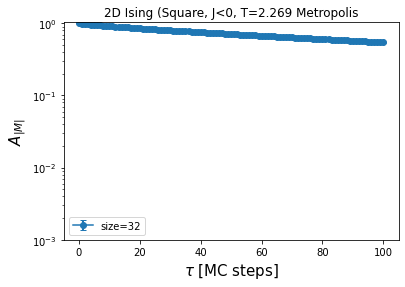

In [16]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_32_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title(f"2D Ising (Square, J<0, T=2.269 Metropolis")
plt.legend()

In [17]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_32_j_neg_h_0_mean) - 1/2

In [18]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 73.163.


-----------
### Size = 16

In [19]:
with open('./data_2d_ising/af_h_2dising_square/size_16_beta_0.440686_h_0_metropolis', 'rb') as file:
    m_2dising_16_j_neg_h_0 = pickle.load(file)

In [20]:
m_abs_2dising_16_j_neg_h_0 = np.abs(m_2dising_16_j_neg_h_0)

In [21]:
m_abs_2dising_16_j_neg_h_0 = m_abs_2dising_16_j_neg_h_0.reshape((10000, 1000))

In [22]:
m_abs_2dising_16_j_neg_h_0_mean = np.mean(m_abs_2dising_16_j_neg_h_0)

In [23]:
print(f"<|m|> of size 16 is: {m_abs_2dising_16_j_neg_h_0_mean:.3f}.")

<|m|> of size 16 is: 0.714.


In [24]:
time_start = time.time()
autocorr_m_abs_2dising_16_j_neg_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_16_j_neg_h_0, 100)
_, autocorr_m_abs_2dising_16_j_neg_h_0_std = autocorr_mc_std_est(m_abs_2dising_16_j_neg_h_0, 100)
time_end = time.time()
print(time_end-time_start)

131.6569046974182


In [25]:
autocorr_m_abs_2dising_16_j_neg_h_0_mean = np.insert(autocorr_m_abs_2dising_16_j_neg_h_0_mean, 0, 1)

In [26]:
autocorr_m_abs_2dising_16_j_neg_h_0_std = np.insert(autocorr_m_abs_2dising_16_j_neg_h_0_std, 0, 0)

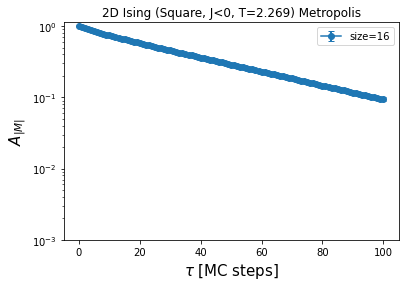

In [27]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_16_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, T=2.269) Metropolis")
plt.legend()

In [28]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_16_j_neg_h_0_mean) - 1/2

In [29]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 36.244.


----
### Size = 8

In [30]:
with open('./data_2d_ising/af_h_2dising_square/size_8_beta_0.441_h_0_metropolis', 'rb') as file:
    m_2dising_8_j_neg_h_0 = pickle.load(file)

In [31]:
m_abs_2dising_8_j_neg_h_0 = np.abs(m_2dising_8_j_neg_h_0)

In [32]:
m_abs_2dising_8_j_neg_h_0_mean = np.mean(m_abs_2dising_8_j_neg_h_0)

In [33]:
print(f"<|m|> of size 8 is: {m_abs_2dising_8_j_neg_h_0_mean:.3f}.")

<|m|> of size 8 is: 0.778.


In [34]:
m_abs_2dising_8_j_neg_h_0 = m_abs_2dising_8_j_neg_h_0.reshape((10000, 1000))

In [35]:
time_start = time.time()
autocorr_m_abs_2dising_8_j_neg_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_8_j_neg_h_0, 100)
_, autocorr_m_abs_2dising_8_j_neg_h_0_std = autocorr_mc_std_est(m_abs_2dising_8_j_neg_h_0, 100)
time_end = time.time()
print(time_end-time_start)

122.1409261226654


In [36]:
autocorr_m_abs_2dising_8_j_neg_h_0_mean = np.insert(autocorr_m_abs_2dising_8_j_neg_h_0_mean, 0, 1)

In [37]:
autocorr_m_abs_2dising_8_j_neg_h_0_std = np.insert(autocorr_m_abs_2dising_8_j_neg_h_0_std, 0, 0)

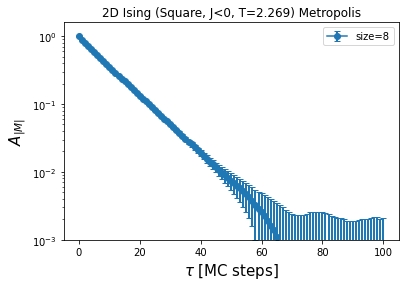

In [38]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_8_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, T=2.269) Metropolis")
plt.legend()

In [39]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_8_j_neg_h_0_mean[:60]) - 1/2

In [40]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 9.696.


-----------
### Size = 4

In [41]:
with open('./data_2d_ising/af_h_2dising_square/size_4_beta_0.441_h_0_metropolis', 'rb') as file:
    m_2dising_4_j_neg_h_0 = pickle.load(file)

In [42]:
m_abs_2dising_4_j_neg_h_0 = np.abs(m_2dising_4_j_neg_h_0)

In [43]:
m_abs_2dising_4_j_neg_h_0_mean = np.mean(m_abs_2dising_4_j_neg_h_0)

In [44]:
print(f"<|m|> of size 4 is: {m_abs_2dising_4_j_neg_h_0_mean:.3f}.")

<|m|> of size 4 is: 0.844.


In [45]:
m_abs_2dising_4_j_neg_h_0 = m_abs_2dising_4_j_neg_h_0.reshape((10000, 1000))

In [46]:
time_start = time.time()
autocorr_m_abs_2dising_4_j_neg_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_4_j_neg_h_0, 100)
_, autocorr_m_abs_2dising_4_j_neg_h_0_std = autocorr_mc_std_est(m_abs_2dising_4_j_neg_h_0, 100)
time_end = time.time()
print(time_end-time_start)

120.52704644203186


In [47]:
autocorr_m_abs_2dising_4_j_neg_h_0_mean = np.insert(autocorr_m_abs_2dising_4_j_neg_h_0_mean, 0, 1)

In [48]:
autocorr_m_abs_2dising_4_j_neg_h_0_std = np.insert(autocorr_m_abs_2dising_4_j_neg_h_0_std, 0, 0)

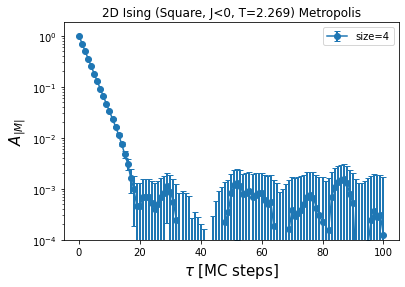

In [49]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_4_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, T=2.269) Metropolis")
plt.legend()

In [50]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_4_j_neg_h_0_mean[:20]) - 1/2

In [51]:
print(f"autocorr time of size 16 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 16 is: 2.925.


--------------
#### Summary

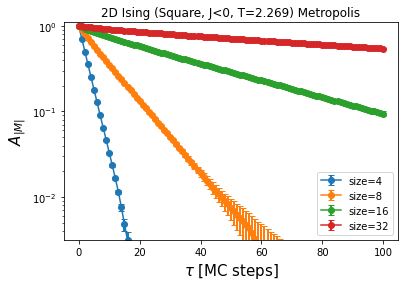

In [52]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_4_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_4_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_8_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_8_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_16_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_16_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_32_j_neg_h_0_mean, yerr=autocorr_m_abs_2dising_32_j_neg_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-2.5, 1.1)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, T=2.269) Metropolis")
plt.legend()

### Size effect and Dynamical Exponent

In [53]:
size_array = np.array([4, 8, 16, 32])

In [54]:
m_mean_abs_array = np.array([m_abs_2dising_4_j_neg_h_0_mean, 
                             m_abs_2dising_8_j_neg_h_0_mean,
                             m_abs_2dising_16_j_neg_h_0_mean,
                             m_abs_2dising_32_j_neg_h_0_mean])

Text(0.5, 1.0, 'Size Effect on Square 2D Ising (J < 0, h = 0) Metropolis')

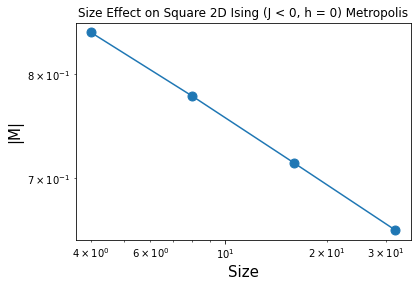

In [55]:
plt.plot(size_array, m_mean_abs_array, '-o', markersize=9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size Effect on Square 2D Ising (J < 0, h = 0) Metropolis")

In [56]:
autocorr_time_array = np.array([autocorr_time_size_4, autocorr_time_size_8, 
                                autocorr_time_size_16, autocorr_time_size_32])
size_array = np.array([4, 8, 16, 32])

In [57]:
index_metropolis, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [58]:
print(f"index of metropolis is about: {index_metropolis:.3f}.")

index of metropolis is about: 1.584.


Text(0.5, 1.0, 'Metropolis on Ising 2D Square Lattice (J < 0, h = 0), Z=1.584')

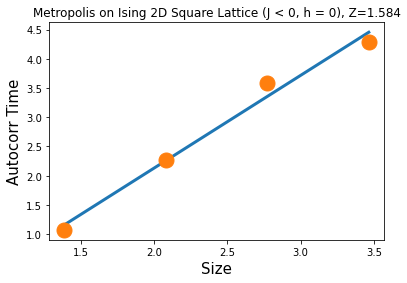

In [59]:
plt.plot(np.log(size_array), index_metropolis*np.log(size_array) + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_time_array), 'o', markersize=15)
plt.xlabel("Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Metropolis on Ising 2D Square Lattice (J < 0, h = 0), Z=1.584")

--------------------
## Chain Evolution on Square Lattice (J < 0)

### Size = 4

In [60]:
with open('./data_2d_ising/af_h_2dising_square/size_4_beta_0.441_h_0_chain_1E7.pkl', 'rb') as file:
    m_2dising_size_4_square_neg_j_h_0 = pickle.load(file)

In [61]:
m_abs_2dising_size_4_square_neg_j_h_0 = np.abs(m_2dising_size_4_square_neg_j_h_0)

In [62]:
m_abs_2dising_size_4_square_neg_j_h_0_mean = np.mean(m_abs_2dising_size_4_square_neg_j_h_0)

In [63]:
print(f"|m| of size 4 is: {m_abs_2dising_size_4_square_neg_j_h_0_mean}.")

|m| of size 4 is: 0.8438175125.


In [64]:
m_abs_2dising_size_4_square_neg_j_h_0 = m_abs_2dising_size_4_square_neg_j_h_0.reshape((10000, 1000))

In [70]:
time_start = time.time()
autocorr_m_abs_2dising_size_4_square_neg_j_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_4_square_neg_j_h_0, 100)
_, autocorr_m_abs_2dising_size_4_square_neg_j_h_0_std = autocorr_mc_std_est(m_abs_2dising_size_4_square_neg_j_h_0, 100)
time_end = time.time()
print(time_end-time_start)

143.6234006881714


In [71]:
autocorr_m_abs_2dising_size_4_square_neg_j_h_0_mean = np.insert(autocorr_m_abs_2dising_size_4_square_neg_j_h_0_mean, 0, 1)

In [72]:
autocorr_m_abs_2dising_size_4_square_neg_j_h_0_std = np.insert(autocorr_m_abs_2dising_size_4_square_neg_j_h_0_std, 0, 0)

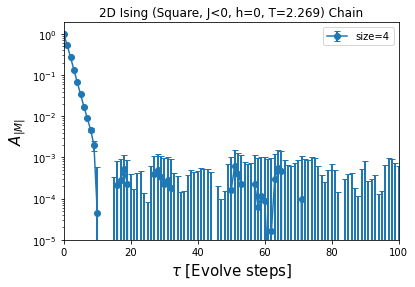

In [73]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_4_square_neg_j_h_0_mean, yerr=autocorr_m_abs_2dising_size_4_square_neg_j_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-5)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, h=0, T=2.269) Chain")
plt.legend()

In [74]:
autocorr_time_size_4 = np.sum(autocorr_m_abs_2dising_size_4_square_neg_j_h_0_mean[:20]) - 1/2

In [75]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 1.577.


-----
### Size = 8

In [76]:
with open('./data_2d_ising/af_h_2dising_square/size_8_beta_0.441_h_0_chain_1E7.pkl', 'rb') as file:
    m_2dising_size_8_square_neg_j_h_0 = pickle.load(file)

In [77]:
m_abs_2dising_size_8_square_neg_j_h_0 = np.abs(m_2dising_size_8_square_neg_j_h_0)

In [78]:
m_abs_2dising_size_8_square_neg_j_h_0_mean = np.mean(m_abs_2dising_size_8_square_neg_j_h_0)

In [79]:
print(f"|m| of size 8 is: {m_abs_2dising_size_8_square_neg_j_h_0_mean}.")

|m| of size 8 is: 0.7773531875.


In [80]:
m_abs_2dising_size_8_square_neg_j_h_0 = m_abs_2dising_size_8_square_neg_j_h_0.reshape((10000, 1000))

In [81]:
time_start = time.time()
autocorr_m_abs_2dising_size_8_square_neg_j_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_8_square_neg_j_h_0, 100)
_, autocorr_m_abs_2dising_size_8_square_neg_j_h_0_std = autocorr_mc_std_est(m_abs_2dising_size_8_square_neg_j_h_0, 100)
time_end = time.time()
print(time_end-time_start)

121.88286876678467


In [82]:
autocorr_m_abs_2dising_size_8_square_neg_j_h_0_mean = np.insert(autocorr_m_abs_2dising_size_8_square_neg_j_h_0_mean, 0, 1)

In [83]:
autocorr_m_abs_2dising_size_8_square_neg_j_h_0_std = np.insert(autocorr_m_abs_2dising_size_8_square_neg_j_h_0_std, 0, 0)

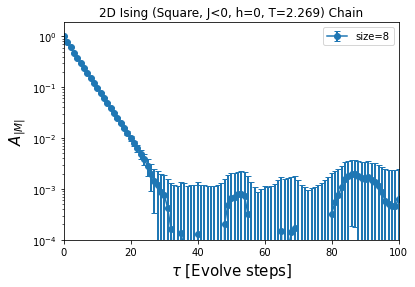

In [84]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_8_square_neg_j_h_0_mean, yerr=autocorr_m_abs_2dising_size_8_square_neg_j_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-4)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, h=0, T=2.269) Chain")
plt.legend()

In [85]:
autocorr_time_size_8 = np.sum(autocorr_m_abs_2dising_size_8_square_neg_j_h_0_mean[:35]) - 1/2

In [86]:
print(f"autocorr time of size 8 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 8 is: 4.224.


-------
### Size = 16

In [87]:
with open('./data_2d_ising/af_h_2dising_square/size_16_beta_0.441_h_0_chain_1E7.pkl', 'rb') as file:
    m_2dising_size_16_square_neg_j_h_0 = pickle.load(file)

In [88]:
m_abs_2dising_size_16_square_neg_j_h_0 = np.abs(m_2dising_size_16_square_neg_j_h_0)

In [89]:
m_abs_2dising_size_16_square_neg_j_h_0_mean = np.mean(m_abs_2dising_size_16_square_neg_j_h_0)

In [90]:
print(f"|m| of size 16 is: {m_abs_2dising_size_16_square_neg_j_h_0_mean}.")

|m| of size 16 is: 0.71355016484375.


In [91]:
m_abs_2dising_size_16_square_neg_j_h_0 = m_abs_2dising_size_16_square_neg_j_h_0.reshape((10000, 1000))

In [92]:
time_start = time.time()
autocorr_m_abs_2dising_size_16_square_neg_j_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_16_square_neg_j_h_0, 100)
_, autocorr_m_abs_2dising_size_16_square_neg_j_h_0_std = autocorr_mc_std_est(m_abs_2dising_size_16_square_neg_j_h_0, 100)
time_end = time.time()
print(time_end-time_start)

121.38899445533752


In [93]:
autocorr_m_abs_2dising_size_16_square_neg_j_h_0_mean = np.insert(autocorr_m_abs_2dising_size_16_square_neg_j_h_0_mean, 0, 1)

In [94]:
autocorr_m_abs_2dising_size_16_square_neg_j_h_0_std = np.insert(autocorr_m_abs_2dising_size_16_square_neg_j_h_0_std, 0, 0)

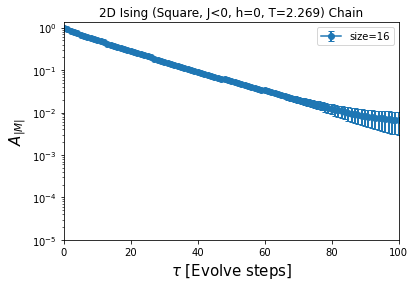

In [95]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_16_square_neg_j_h_0_mean, yerr=autocorr_m_abs_2dising_size_16_square_neg_j_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-5)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, h=0, T=2.269) Chain")
plt.legend()

In [96]:
autocorr_time_size_16 = np.sum(autocorr_m_abs_2dising_size_16_square_neg_j_h_0_mean) - 1/2

In [97]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 16.009.


-----
### Size = 32

In [98]:
with open('./data_2d_ising/af_h_2dising_square/size_32_beta_0.441_h_0_chain_1E7.pkl', 'rb') as file:
    m_2dising_size_32_square_neg_j_h_0 = pickle.load(file)

In [99]:
m_abs_2dising_size_32_square_neg_j_h_0 = np.abs(m_2dising_size_32_square_neg_j_h_0)

In [100]:
m_abs_2dising_size_32_square_neg_j_h_0_mean = np.mean(m_abs_2dising_size_32_square_neg_j_h_0)

In [101]:
print(f"|m| of size 32 is: {m_abs_2dising_size_32_square_neg_j_h_0_mean}.")

|m| of size 32 is: 0.6552981296875.


In [102]:
m_abs_2dising_size_32_square_neg_j_h_0 = m_abs_2dising_size_32_square_neg_j_h_0.reshape((10000, 1000))

In [103]:
time_start = time.time()
autocorr_m_abs_2dising_size_32_square_neg_j_h_0_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_size_32_square_neg_j_h_0, 100)
_, autocorr_m_abs_2dising_size_32_square_neg_j_h_0_std = autocorr_mc_std_est(m_abs_2dising_size_32_square_neg_j_h_0, 100)
time_end = time.time()
print(time_end-time_start)

123.08803176879883


In [104]:
autocorr_m_abs_2dising_size_32_square_neg_j_h_0_mean = np.insert(autocorr_m_abs_2dising_size_32_square_neg_j_h_0_mean, 0, 1)

In [105]:
autocorr_m_abs_2dising_size_32_square_neg_j_h_0_std = np.insert(autocorr_m_abs_2dising_size_32_square_neg_j_h_0_std, 0, 0)

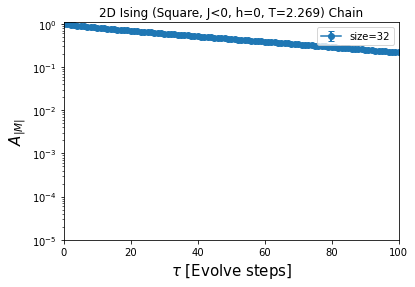

In [106]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_32_square_neg_j_h_0_mean, yerr=autocorr_m_abs_2dising_size_32_square_neg_j_h_0_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-5)
plt.xlim(0, 100)
plt.xlabel(r'$\tau$ [Evolve steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, h=0, T=2.269) Chain")
plt.legend()

In [107]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_size_32_square_neg_j_h_0_mean) - 1/2

In [108]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 49.256.


------
### Summary

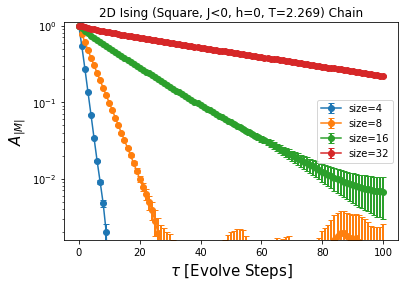

In [112]:
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_4_square_neg_j_h_0_mean, 
             yerr=autocorr_m_abs_2dising_size_4_square_neg_j_h_0_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=4')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_8_square_neg_j_h_0_mean, 
             yerr=autocorr_m_abs_2dising_size_8_square_neg_j_h_0_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=8')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_16_square_neg_j_h_0_mean, 
             yerr=autocorr_m_abs_2dising_size_16_square_neg_j_h_0_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=16')
plt.errorbar(x=range(101), y=autocorr_m_abs_2dising_size_32_square_neg_j_h_0_mean, 
             yerr=autocorr_m_abs_2dising_size_32_square_neg_j_h_0_std, fmt='-o', capsize=3, 
             elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-2.8, 1.1)
plt.xlabel(r'$\tau$ [Evolve Steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J<0, h=0, T=2.269) Chain")
plt.legend()

-------
### dynamical exponent

In [113]:
autocorr_time_array = np.array([autocorr_time_size_4, autocorr_time_size_8, 
                                autocorr_time_size_16, autocorr_time_size_32])
size_array = np.array([4, 8, 16, 32])

In [114]:
index_chain, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [115]:
print(f"index of chain evolution is about: {index_chain:.3f}.")

index of chain evolution is about: 1.682.


Text(0.5, 1.0, 'Chain on Ising 2D Square Lattice (J < 0, h=0), Z=1.672')

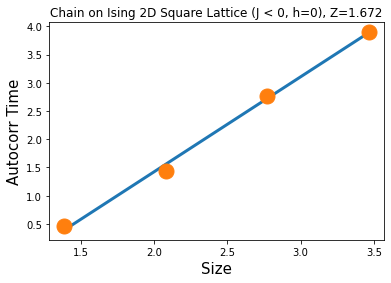

In [116]:
plt.plot(np.log(size_array), index_chain*np.log(size_array) + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_time_array), 'o', markersize=15)
plt.xlabel("Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Chain on Ising 2D Square Lattice (J < 0, h=0), Z=1.672")

-----
### Size effects

In [117]:
size_array = np.array([4, 8, 16, 32])

In [120]:
m_abs_array = np.array([m_abs_2dising_size_4_square_neg_j_h_0_mean, 
                        m_abs_2dising_size_8_square_neg_j_h_0_mean,
                        m_abs_2dising_size_16_square_neg_j_h_0_mean,
                        m_abs_2dising_size_32_square_neg_j_h_0_mean])

In [122]:
coef_autocorr, bias = np. polyfit(size_array, m_abs_array, 1)

Text(0.5, 1.0, 'Size effect on 2D Ising Square Lattice (J < 0)')

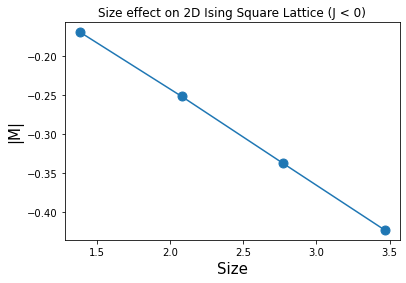

In [123]:
#plt.plot(size_array, coef_autocorr*size_array + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(m_abs_array), '-o', markersize=9)
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size effect on 2D Ising Square Lattice (J < 0)")